In [21]:
import skimage
import numpy as np
import imageio
import scipy.signal
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
from scipy import fft

In [22]:
def my_rgb_to_gray(img):
    gray_img = imageio.core.util.Array(np.array([np.zeros(img.shape[1]) for i in range(0, img.shape[0])]))
    for i in range(0,  img.shape[0]):
        for j in range(0, img.shape[1]):
            gray_img[i][j] = (img[i][j] * np.array([0.2126, 0.7152, 0.0722])).sum()
    return gray_img


def extend(size, img):
    new_img = imageio.core.util.Array(np.array([np.zeros(img.shape[1] + 2 * size) for i in range(0, img.shape[0] + 2 * size)]))
    new_img[size:img.shape[0] + size,  size:img.shape[1] + size] = img.copy()
    for i in range(0, size):
        for j in range(0, img.shape[0]):
            new_img[j + size][i] = new_img[j+ size][size]
            new_img[j + size][i + size + img.shape[1]] = new_img[j + size][size + img.shape[1] - 1]
    for i in range(0, size):
        for j in range(0, new_img.shape[1]):
            new_img[i][j] = new_img[size][j]
            new_img[size + img.shape[0] + i][j] = new_img[size + img.shape[0] - 1][j]
    return new_img

def convolve(img, kernel):
    ext = kernel.shape[0] // 2
    new_img = extend(ext, img)
    #new_img = img
    conv = fftconvolve(new_img, kernel, mode = 'same')
    res = conv[ext: conv.shape[0] - ext, ext: conv.shape[1] - ext]
    return res
    #return conv

def gradient_of_tv(img):
    grad_of_tv_x = np.sign(scipy.ndimage.shift(img, (0, 1), mode = 'nearest') - img)
    grad_of_tv_x = scipy.ndimage.shift(grad_of_tv_x, (0, -1), mode = 'nearest') - grad_of_tv_x
    grad_of_tv_y = np.sign(scipy.ndimage.shift(img, (1, 0), mode = 'nearest') - img)
    grad_of_tv_y = scipy.ndimage.shift(grad_of_tv_y, (-1, 0), mode = 'nearest') - grad_of_tv_y
    return grad_of_tv_y + grad_of_tv_x

def gradient_of_conv (img, kernel, conj_kernel, blurred):
    return (2 * convolve(convolve(img, kernel), conj_kernel) - 2 * convolve(blurred, conj_kernel))

def gradient(img, kernel, conj_kernel, blurred):
    alpha = 0.1
    grad_from_conv = gradient_of_conv (img, kernel, conj_kernel, blurred)
    grad_from_tv = gradient_of_tv(img)
    res = grad_from_conv + alpha * grad_from_tv
    return res

def gradient_descent (kernel, blurred, n_iters):
    conj_kernel = np.zeros(kernel.shape)
    center_x = kernel.shape[0]//2
    center_y = kernel.shape[1]//2
    for i in range(0, center_x):
        for j in range(0, center_y):
            conj_kernel[center_x - i][center_y - j] = kernel[center_x + i][center_y + j]
            conj_kernel[center_x + i][center_y + j] = kernel[center_x - i][center_y - j]
            conj_kernel[center_x - i][center_y + j] = kernel[center_x + i][center_y - j]
            conj_kernel[center_x + i][center_y - j] = kernel[center_x - i][center_y + j]
    print(conj_kernel.sum())
    current = np.zeros(blurred.shape)
    v_k = np.zeros(blurred.shape)
    current[0][0] = 1.
    beta = 0.1
    for i in range(0, n_iters):
        step = 0.9/(1 + float(i)/16)
        #step = 0.8
        v_k = beta * v_k - gradient(current, kernel, conj_kernel, blurred)
        current = current + step * v_k
        print("mse(img, current): ", mse(img, current), "    current energy: ", energy(current, kernel, blurred))
        
    return current
    
def energy(img, kernel, blurred):
    return np.sum(((convolve(img, kernel)) - blurred)**2)

def conj_grad_conv(x_0, kernel, b, n_iters):
    #r_k, r_k_m1, a_k_p1, b_k_p1, p_k_p1, Kp_k_p1, x_k, x_k_p1
    x_k = x_0
    b_vec = b.flatten()
    r_k = b_vec - fftconvolve(x_0, kernel, mode = 'same').flatten()
    p_k_p1 = r_k
    Kp_k_p1 = fftconvolve(p_k_p1.reshape(kernel.shape), kernel, mode = 'same').flatten()
    a_k_p1 = np.sum(r_k ** 2)/np.sum(p_k_p1 * Kp_k_p1)
    print("a_k+1 ", a_k_p1)
    x_k_p1 = x_k + a_k_p1 * p_k_p1.reshape(kernel.shape)
    for k in range(0, n_iters):
        x_k = x_k_p1
        p_k = p_k_p1
        norm_r_k_m1 = np.sum(r_k ** 2)
        r_k = r_k - a_k_p1 * Kp_k_p1
        b_k_p1 = np.sum(r_k ** 2)/norm_r_k_m1
        p_k_p1 = r_k + b_k_p1 * p_k
        Kp_k_p1 = fftconvolve(p_k_p1.reshape(kernel.shape), kernel, mode = 'same').flatten()
        a_k_p1 = np.sum(r_k ** 2)/np.sum(p_k_p1 * Kp_k_p1)
        #print("a_k+1 ", a_k_p1)
        print(np.sum((fftconvolve(x_k, kernel, mode = 'same') - blurred) ** 2))
        x_k_p1 = x_k + a_k_p1 * p_k_p1.reshape(kernel.shape)
    return x_k_p1

def total_variation (img):
    return np.sum(np.abs(scipy.ndimage.shift(img, (1, 0), mode = 'nearest') - img)) + np.sum(np.abs(scipy.ndimage.shift(img, (0, 1), mode = 'nearest') - img))

def energy(img, kernel, blurred):
    conv_energy = np.sum(((scipy.signal.fftconvolve(img, kernel, mode = "same")) - blurred)**2)
    alpha = 0.5
    return conv_energy / (img.shape[0] * img.shape[1])#+ alpha * total_variation(img)

def mse(img1, img2):
    return np.sum((img1 - img2) ** 2)/(img1.shape[0] * img1.shape[1] )


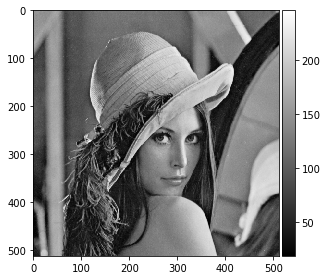

In [23]:
img = 255 * skimage.color.rgb2gray(skimage.io.imread("lena.bmp"))
#lena = my_rgb_to_gray(skimage.io.imread("lena.bmp"))
skimage.io.imshow(img, cmap = "gray")

1.0
0.9333333333333333


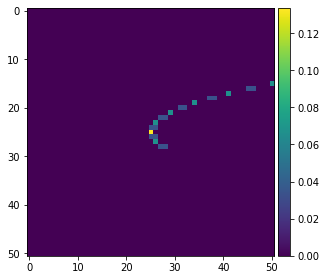

In [24]:
kernel = np.zeros((51, 51), dtype = float)
kernel[25][25] = 4
for i in range (-3, 11):
    kernel[25 - i][25 + int(np.floor((float(i) /2) ** 2))] += 1
    kernel[25 - i][25 + int(np.ceil((float(i) /2) ** 2))] += 2
    kernel[25 - i][25 + int(np.round((float(i) /2) ** 2))] += 1

kernel /= kernel.sum()
print(kernel.sum())

conj_kernel = np.zeros(kernel.shape)
center_x = kernel.shape[0]//2
center_y = kernel.shape[1]//2
for i in range(0, center_x):
    for j in range(0, center_y):
        conj_kernel[center_x - i][center_y - j] = kernel[center_x + i][center_y + j]
        conj_kernel[center_x + i][center_y + j] = kernel[center_x - i][center_y - j]
        conj_kernel[center_x - i][center_y + j] = kernel[center_x + i][center_y - j]
        conj_kernel[center_x + i][center_y - j] = kernel[center_x - i][center_y + j]
print(conj_kernel.sum())
skimage.io.imshow(kernel)

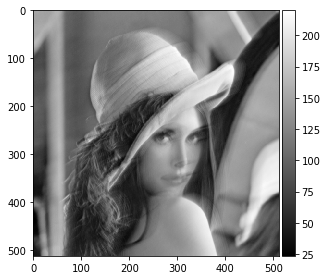

In [25]:
blurred = convolve(img, kernel)
skimage.io.imshow(blurred, cmap = 'gray')

0.9333333333333333
mse(img, current):  7070.700996292393     current energy:  6544.661472656344
mse(img, current):  912.997222920377     current energy:  943.1226319335501
mse(img, current):  81.04511661567702     current energy:  103.64250634471341
mse(img, current):  51.677878776888726     current energy:  95.17365673587122
mse(img, current):  39.24468612278799     current energy:  96.87059907562697
mse(img, current):  32.24462756671316     current energy:  94.07513797957738
mse(img, current):  27.85995634334644     current energy:  93.4481507788642
mse(img, current):  24.710439100212234     current energy:  93.32505451112482
mse(img, current):  22.357268605049043     current energy:  93.13823752825868
mse(img, current):  20.53750173545928     current energy:  92.98156215293832
mse(img, current):  19.092358592069928     current energy:  92.87710871872855
mse(img, current):  17.919408904542458     current energy:  92.79852518432534
mse(img, current):  16.950239990861352     current en

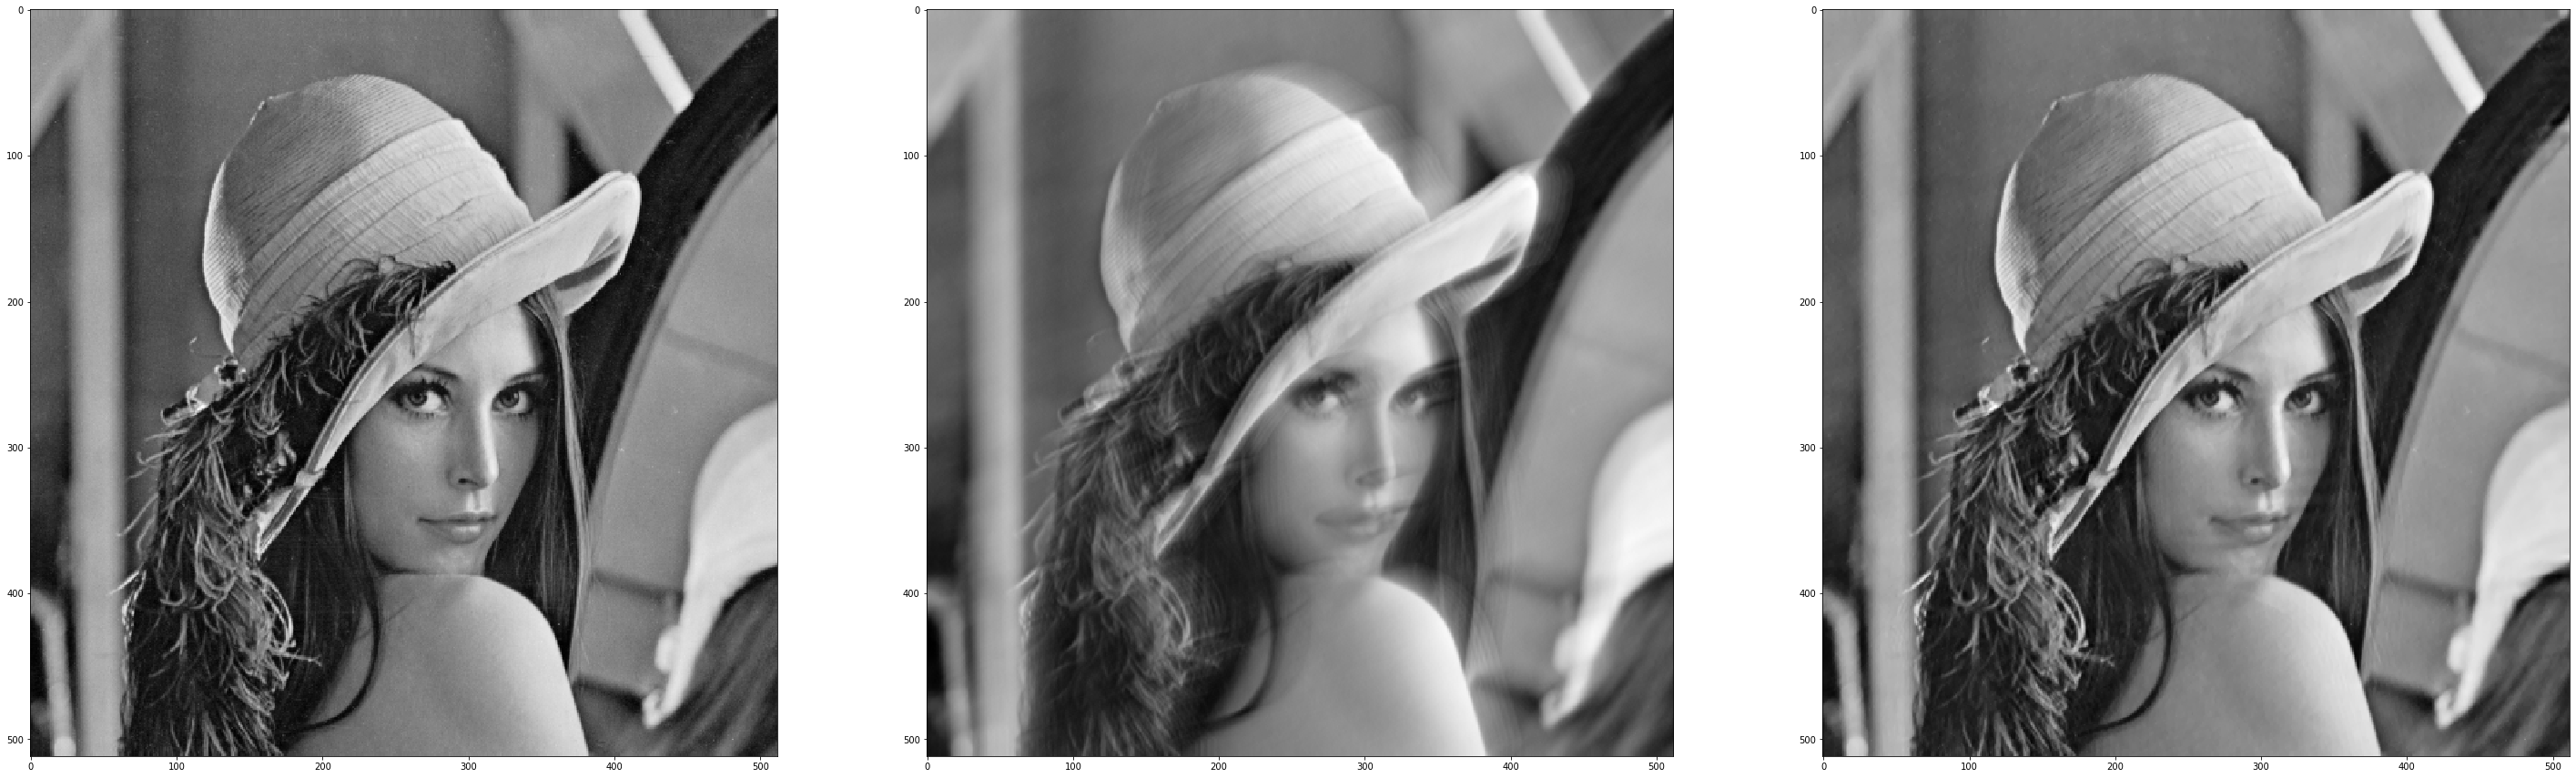

In [28]:
current = gradient_descent(kernel, blurred, 20)

imgs = [img, blurred, current]
_, axs = plt.subplots(ncols = len(imgs), figsize = (50, 50))

for index in range(0, len(imgs)):
    axs[index].imshow(imgs[index], cmap = "gray")